---
<h1 style="text-align: center;">
CSCI 4521: Applied Machine Learning (Fall 2024)
</h1>

<h1 style="text-align: center;">
Homework 3
</h1>

<h3 style="text-align: center;">
(Due Tue, Oct. 29, 11:59 PM CT)
</h3>

---

### The RMS Titanic was a British ocean liner considered by many as "unsinkable." Unfortunately, the Titanic hit an iceberge and sank on April 15, 1912 on her trip from Southampton, England to New York City, USA. There were not enough lifeboards onboard for everyone and, as a result, an estimated 1500 people died out of the 2224 passengers and crew onboard. The Titanic disaster was one of the deadliest ship sinkings. There was a large element of luck involved in surviving the shipwreck but some people were more likely to survive than others.

![rms-titanic-14047.png](attachment:d3b8257e-f179-4545-8953-e44343a5f64d.png)


### In this homework, your task is to predict whether a passenger will survive the shipwreck or not. You need to use machine learning and develop classification models to accomplish this task. The only data you have available is passenger data in the dataset `titanic_dataset_csci4521.csv` which consists of the following features:
- ### Passenger ID,
- ### Ticket class (1 = first class, 2 = second class, 3 = third class),
- ### Passenger name,
- ### Sex,
- ### Age,
- ### Number of siblings or spouses aboard,
- ### Number of parents or children aboard,
- ### Ticket number,
- ### Fare,
- ### Cabin number, and
- ### Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)
### and label:
- ### Survived ($y_i=1$) or
- ### Not survived ($y_i = 0$).
### You must decide if and how to clean and preprocess the data, which classification algorithms to use, which and how to tune any hyperparameters, how to measure performance, which models to select, and which final model to use.

### You can use any of the coding packages we've used in class (numpy, pandas, pyspark, scikit-learn, etc.) and you must write and submit working code. Reminder, you cannot use ChatGPT or similar technologies. Please see the syllabus for more details.

### You also need to submit a short report of your work describing all steps you took, explanations of why you took those steps, results, what you learned, how you might use what you learned in the future, and your conclusions. We expect the report to be well-written and clearly describe everything you've done and why.

---

### Write your code here

In [191]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz
# !tar xf spark-3.5.3-bin-hadoop3.tgz
# !pip install -q findspark

# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"

In [192]:
import findspark
findspark.init()
from pyspark.sql import SparkSession, DataFrame
spark = SparkSession.builder.getOrCreate()
import pyspark.sql.functions  as F
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler,StandardScaler
from sklearn.model_selection import  cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns

In [193]:
def load_data(path: str) -> DataFrame:
    df = spark.read.csv(path, header=True, inferSchema=True)
    return df

df = load_data("titanic_dataset_csci4521.csv")
df = df.drop("Name")
df = df.drop("Ticket")
df.show(30)
df.drop()
target = df.select("Survived")
features = [col for col in df.columns if col != "Survived" and col != "PassengerId"]

+-----------+--------+------+------+----+-----+-----+-------+-----------+--------+
|PassengerId|Survived|Pclass|   Sex| Age|SibSp|Parch|   Fare|      Cabin|Embarked|
+-----------+--------+------+------+----+-----+-----+-------+-----------+--------+
|          1|       0|     3|  male|22.0|    1|    0|   7.25|       NULL|       S|
|          2|       1|     1|female|38.0|    1|    0|71.2833|        C85|       C|
|          3|       1|     3|female|26.0|    0|    0|  7.925|       NULL|       S|
|          4|       1|     1|female|35.0|    1|    0|   53.1|       C123|       S|
|          5|       0|     3|  male|35.0|    0|    0|   8.05|       NULL|       S|
|          6|       0|     3|  male|NULL|    0|    0| 8.4583|       NULL|       Q|
|          7|       0|     1|  male|54.0|    0|    0|51.8625|        E46|       S|
|          8|       0|     3|  male| 2.0|    3|    1| 21.075|       NULL|       S|
|          9|       1|     3|female|27.0|    0|    2|11.1333|       NULL|       S|
|   

In [194]:
def analyze_data(df: DataFrame,features: list) -> None:
    print(f"Number of samples: {df.count()}")
    print(f"Number of features: {len(features)}")
    for f in features:
        if f == "Cabin":
            missing_values = df.filter(F.col("Cabin").isNull())
            print(f"Number of missing cabin values: {missing_values.count()}")
            df.filter(F.col("Cabin").isNotNull() & (F.col("Cabin") != "")).select("Cabin", "Fare", "Pclass").show(30)
        else:
            df.select(F.mode(F.col(f)), F.mean(F.col(f)),F.stddev(F.col(f)), F.min(F.col(f)), F.max(F.col(f))).show()

analyze_data(df, features)
# 1st class cutoff: ≥ 35.5
# 2nd class cutoff: ≥ 10.5
# 3rd class cutoff: < 10.5

Number of samples: 894
Number of features: 8
+------------+------------------+------------------+-----------+-----------+
|mode(Pclass)|       avg(Pclass)|    stddev(Pclass)|min(Pclass)|max(Pclass)|
+------------+------------------+------------------+-----------+-----------+
|           3|2.3080407701019254|0.8358553066015733|          1|          3|
+------------+------------------+------------------+-----------+-----------+

+---------+--------+-----------+--------+--------+
|mode(Sex)|avg(Sex)|stddev(Sex)|min(Sex)|max(Sex)|
+---------+--------+-----------+--------+--------+
|     male|    NULL|       NULL|  female|    male|
+---------+--------+-----------+--------+--------+

+---------+-----------------+-----------------+--------+--------+
|mode(Age)|         avg(Age)|      stddev(Age)|min(Age)|max(Age)|
+---------+-----------------+-----------------+--------+--------+
|     24.0|30.48627094972067|23.72384742035713|   -17.0|   500.0|
+---------+-----------------+-----------------+--

In [195]:
def replace_missing(df: DataFrame, features: list) -> DataFrame:

    for f in features:

        if f == "Age":
            resonable_ages = df.filter((F.col(f) >= 0) & (F.col(f) <= 100))
            avg_age = resonable_ages.select(F.mean(F.col(f))).collect()[0][0]
            df = df.withColumn(f, F.when(F.col(f).isNull(), avg_age).otherwise(F.col(f))) #
        elif f == "Cabin":
            df = df.withColumn(f,
                               F.when(F.col("Fare") >= 35.5, "A").when((F.col("Fare") >= 10.5) & (F.col("Fare") < 35.5),
                                                                        "B").otherwise("C"))
        elif f == "Pclass":
            df = df.withColumn(f, F.when(F.col("Fare") >= 35.5, 1).when((F.col("Fare") >= 10.5) & (F.col("Fare") < 35.5),
                                                                        2).otherwise(3))
        else:
            mode = df.select(F.mode(F.col(f))).collect()[0][0]
            df = df.withColumn(f, F.when(F.col(f).isNull(), mode).otherwise(F.col(f)))
    return df

df = replace_missing(df, features)
df.show(30)

+-----------+--------+------+------+------------------+-----+-----+-------+-----+--------+
|PassengerId|Survived|Pclass|   Sex|               Age|SibSp|Parch|   Fare|Cabin|Embarked|
+-----------+--------+------+------+------------------+-----+-----+-------+-----+--------+
|          1|       0|     3|  male|              22.0|    1|    0|   7.25|    C|       S|
|          2|       1|     1|female|              38.0|    1|    0|71.2833|    A|       C|
|          3|       1|     3|female|              26.0|    0|    0|  7.925|    C|       S|
|          4|       1|     1|female|              35.0|    1|    0|   53.1|    A|       S|
|          5|       0|     3|  male|              35.0|    0|    0|   8.05|    C|       S|
|          6|       0|     3|  male|29.702485955056176|    0|    0| 8.4583|    C|       Q|
|          7|       0|     1|  male|              54.0|    0|    0|51.8625|    A|       S|
|          8|       0|     2|  male|               2.0|    3|    1| 21.075|    B|       S|

In [196]:
print(f"Before removing duplicates:{df.count()}")
def remove_duplicates(df: DataFrame):
    duplicates = df.groupBy("PassengerId").count().where(F.col("count") > 1)
    duplicates.show()
    df = df.dropDuplicates(["PassengerId"])
    return df

df = remove_duplicates(df)
df.show(30)
print(f"After removing duplicates:{df.count()}")

Before removing duplicates:894
+-----------+-----+
|PassengerId|count|
+-----------+-----+
|        164|    2|
|        510|    2|
|        334|    2|
+-----------+-----+

+-----------+--------+------+------+------------------+-----+-----+-------+-----+--------+
|PassengerId|Survived|Pclass|   Sex|               Age|SibSp|Parch|   Fare|Cabin|Embarked|
+-----------+--------+------+------+------------------+-----+-----+-------+-----+--------+
|          1|       0|     3|  male|              22.0|    1|    0|   7.25|    C|       S|
|          2|       1|     1|female|              38.0|    1|    0|71.2833|    A|       C|
|          3|       1|     3|female|              26.0|    0|    0|  7.925|    C|       S|
|          4|       1|     1|female|              35.0|    1|    0|   53.1|    A|       S|
|          5|       0|     3|  male|              35.0|    0|    0|   8.05|    C|       S|
|          6|       0|     3|  male|29.702485955056176|    0|    0| 8.4583|    C|       Q|
|        

In [197]:
analyze_data(df,features)

Number of samples: 891
Number of features: 8
+------------+------------------+-----------------+-----------+-----------+
|mode(Pclass)|       avg(Pclass)|   stddev(Pclass)|min(Pclass)|max(Pclass)|
+------------+------------------+-----------------+-----------+-----------+
|           2|2.1582491582491583|0.760460289862104|          1|          3|
+------------+------------------+-----------------+-----------+-----------+

+---------+--------+-----------+--------+--------+
|mode(Sex)|avg(Sex)|stddev(Sex)|min(Sex)|max(Sex)|
+---------+--------+-----------+--------+--------+
|     male|    NULL|       NULL|  female|    male|
+---------+--------+-----------+--------+--------+

+------------------+-----------------+------------------+--------+--------+
|         mode(Age)|         avg(Age)|       stddev(Age)|min(Age)|max(Age)|
+------------------+-----------------+------------------+--------+--------+
|29.702485955056176|30.36611952861944|21.255576857980408|   -17.0|   500.0|
+-------------

In [198]:
print(f'Before removing outliers: {df.count()}')
def remove_outliers(df: DataFrame, features: list) -> DataFrame:
    result = df

    for f in features:
        if f not in ["Age", "Fare", "SibSp", "Parch"]:
            continue

        if f == "Age":
            result = result.filter((F.col(f) >= 0) & (F.col(f) <= 100))

        elif f == "Fare":
            result = result.filter(F.col(f) <= 350)

        elif f == "SibSp" or f == "Parch":
            result = result.filter((F.col(f) >= 0) & (F.col(f) <= 10))

        avg_val = result.select(F.mean(F.col(f))).collect()[0][0]
        std_val = result.select(F.stddev(F.col(f))).collect()[0][0]

        if std_val is None or avg_val is None:
            continue
        cut_off = 3 * std_val
        lower = avg_val - cut_off
        upper = avg_val + cut_off
        result = result.filter(F.col(f).between(lower, upper))

    return result

df = remove_outliers(df, features)
target = df.select("Survived")
print(f"After removing outliers: {df.count()}")
df.show(30)

Before removing outliers: 891
After removing outliers: 808
+-----------+--------+------+------+------------------+-----+-----+--------+-----+--------+
|PassengerId|Survived|Pclass|   Sex|               Age|SibSp|Parch|    Fare|Cabin|Embarked|
+-----------+--------+------+------+------------------+-----+-----+--------+-----+--------+
|          1|       0|     3|  male|              22.0|    1|    0|    7.25|    C|       S|
|          2|       1|     1|female|              38.0|    1|    0| 71.2833|    A|       C|
|          3|       1|     3|female|              26.0|    0|    0|   7.925|    C|       S|
|          4|       1|     1|female|              35.0|    1|    0|    53.1|    A|       S|
|          5|       0|     3|  male|              35.0|    0|    0|    8.05|    C|       S|
|          6|       0|     3|  male|29.702485955056176|    0|    0|  8.4583|    C|       Q|
|          7|       0|     1|  male|              54.0|    0|    0| 51.8625|    A|       S|
|          8|       0

In [199]:
analyze_data(df, features)

Number of samples: 808
Number of features: 8
+------------+----------------+------------------+-----------+-----------+
|mode(Pclass)|     avg(Pclass)|    stddev(Pclass)|min(Pclass)|max(Pclass)|
+------------+----------------+------------------+-----------+-----------+
|           3|2.23019801980198|0.7393885148264666|          1|          3|
+------------+----------------+------------------+-----------+-----------+

+---------+--------+-----------+--------+--------+
|mode(Sex)|avg(Sex)|stddev(Sex)|min(Sex)|max(Sex)|
+---------+--------+-----------+--------+--------+
|     male|    NULL|       NULL|  female|    male|
+---------+--------+-----------+--------+--------+

+------------------+----------------+------------------+--------+--------+
|         mode(Age)|        avg(Age)|       stddev(Age)|min(Age)|max(Age)|
+------------------+----------------+------------------+--------+--------+
|29.702485955056176|29.8433046118867|12.022755391076906|    0.42|    66.0|
+------------------+---

In [200]:
def split_data(df: DataFrame) -> tuple:
    train,test = df.randomSplit([0.8, 0.2], seed=42)
    return train, test

train_df, test_df = split_data(df)
print(f"Train size: {train_df.count()}")
print(f"Test size: {test_df.count()}")

Train size: 678
Test size: 130


In [201]:
def encode_and_standardize(train_df: DataFrame, test_df: DataFrame) -> tuple:
    cat_features = ["Sex", "Embarked", "Cabin"]
    for f in cat_features:
        indexer = StringIndexer(inputCol=f, outputCol=f + "_indexed")
        train_df = indexer.fit(train_df).transform(train_df)
        test_df = indexer.fit(test_df).transform(test_df)
        encoder = OneHotEncoder(inputCol=f + "_indexed", outputCol=f + "_encoded")
        train_df = encoder.fit(train_df).transform(train_df)
        test_df = encoder.fit(test_df).transform(test_df)

    indexer = StringIndexer(inputCol="Survived", outputCol="Label")
    train_df = indexer.fit(train_df).transform(train_df)
    test_df = indexer.fit(test_df).transform(test_df)

    numeric_features = ["Pclass", "Age", "SibSp", "Parch", "Fare"]
    cat_features_encoded = ["Sex_encoded", "Embarked_encoded", "Cabin_encoded"]

    assembler = VectorAssembler(inputCols=numeric_features, outputCol="numeric_features")
    train_df = assembler.transform(train_df)
    test_df = assembler.transform(test_df)

    scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_features", withStd=True, withMean=True)
    train_df = scaler.fit(train_df).transform(train_df)
    test_df = scaler.fit(test_df).transform(test_df)

    assembler = VectorAssembler(inputCols=cat_features_encoded + ["scaled_features"], outputCol="features")
    train_df = assembler.transform(train_df)
    test_df = assembler.transform(test_df)

    train_df = train_df.select("features", "Label")
    test_df = test_df.select("features", "Label")

    return train_df, test_df

train_df, test_df = encode_and_standardize(train_df, test_df)
train_pd = train_df.toPandas()
test_pd = test_df.toPandas()
train_pd.head()

,features,Label
0,"[1.0, 1.0, 0.0, 1.0, 0.0, 1.0356338417914215, ...",0.0
1,"[0.0, 0.0, 1.0, 0.0, 0.0, -1.639260423864141, ...",1.0
2,"[0.0, 1.0, 0.0, 0.0, 0.0, -1.639260423864141, ...",1.0
3,"[1.0, 1.0, 0.0, 1.0, 0.0, 1.0356338417914215, ...",0.0
4,"[1.0, 0.0, 0.0, 1.0, 0.0, 1.0356338417914215, ...",0.0


---

In [202]:
def plot_accuracy(hyperparameters, train_accuracy, test_accuracy, model_name):
    plt.plot(hyperparameters, train_accuracy, label="Train Accuracy")
    plt.plot(hyperparameters, test_accuracy, label="Test Accuracy")
    plt.xlabel("Hyperparameter")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} Accuracy")
    plt.legend()

def create_confusion_matrix(y_true, y_pred, model):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True)
    plt.title(f"{model} Confusion Matrix")
    plt.xlabel("Predicted y")
    plt.ylabel("Actual y")

C=0.001, avg accuracy: 0.613562091503268
C=0.001, train accuracy: 0.6179941002949852
C=0.001, test accuracy: 0.6307692307692307
C=0.01, avg accuracy: 0.7330501089324619
C=0.01, train accuracy: 0.7566371681415929
C=0.01, test accuracy: 0.8076923076923077
C=0.1, avg accuracy: 0.7934967320261438
C=0.1, train accuracy: 0.7935103244837758
C=0.1, test accuracy: 0.7846153846153846
C=1, avg accuracy: 0.7934967320261438
C=1, train accuracy: 0.7935103244837758
C=1, test accuracy: 0.7846153846153846


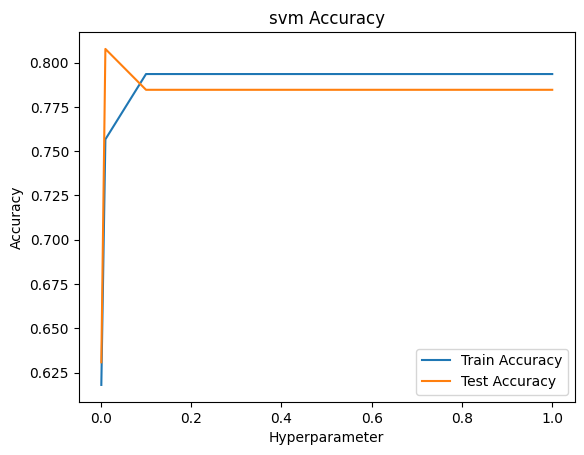

In [203]:
def svm_model(train_pd: pd.DataFrame, test_pd: pd.DataFrame) -> tuple:
    X_train = train_pd["features"].tolist()
    X_test = test_pd["features"].tolist()
    y_train = train_pd["Label"].tolist()
    y_test = test_pd["Label"].tolist()
    test_accuracy = []
    train_accuracy = []
    best_model = None
    best_score = 0

    for c in [0.001,0.01,0.1,1]:
        model = svm.SVC(C=c, kernel="linear",random_state=42)
        scores = cross_val_score(model, X_train, y_train, cv=5)
        print(f"C={c}, avg accuracy: {scores.mean()}")
        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        print(f"C={c}, train accuracy: {train_acc}")
        print(f"C={c}, test accuracy: {test_acc}")
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)

        if test_acc > best_score:
            best_score = test_acc
            best_model = model
    best_pred = best_model.predict(X_test)

    return best_pred, train_accuracy, test_accuracy, y_test


y_pred, train_accuracy, test_accuracy, y_test = svm_model(train_pd, test_pd)
plot_accuracy([0.001,0.01,0.1,1], train_accuracy, test_accuracy, "svm")

Best SVM accuracy: 0.8076923076923077


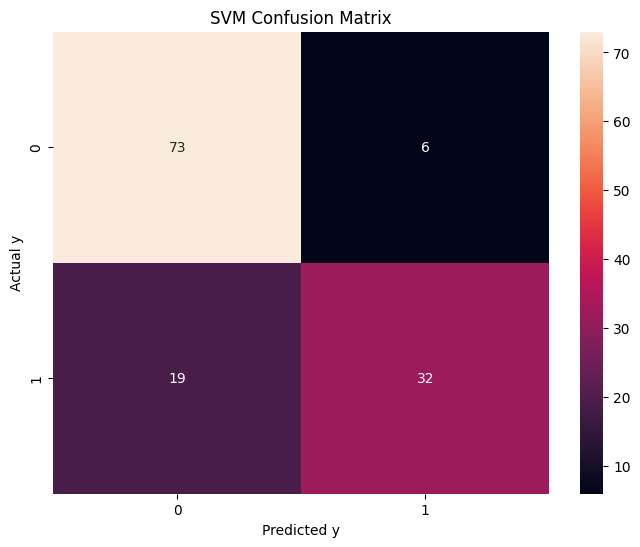

In [204]:
print(f"Best SVM accuracy: {accuracy_score(y_test, y_pred)}")
create_confusion_matrix(y_test, y_pred, "SVM")
# 73 passengers correctly classified as survived
# 32 passengers correctly classified as not survived
# 6 passengers incorrectly classified as survived
# 19 passengers incorrectly classified as not survived

max_iter=35, avg accuracy: 0.7949564270152505
max_iter=35, train accuracy: 0.7979351032448377
max_iter=35, test accuracy: 0.8
max_iter=40, avg accuracy: 0.7949564270152505
max_iter=40, train accuracy: 0.7979351032448377
max_iter=40, test accuracy: 0.8
max_iter=45, avg accuracy: 0.7949564270152505
max_iter=45, train accuracy: 0.7979351032448377
max_iter=45, test accuracy: 0.8
max_iter=50, avg accuracy: 0.7949564270152505
max_iter=50, train accuracy: 0.7979351032448377
max_iter=50, test accuracy: 0.8
max_iter=55, avg accuracy: 0.7949564270152505
max_iter=55, train accuracy: 0.7979351032448377
max_iter=55, test accuracy: 0.8


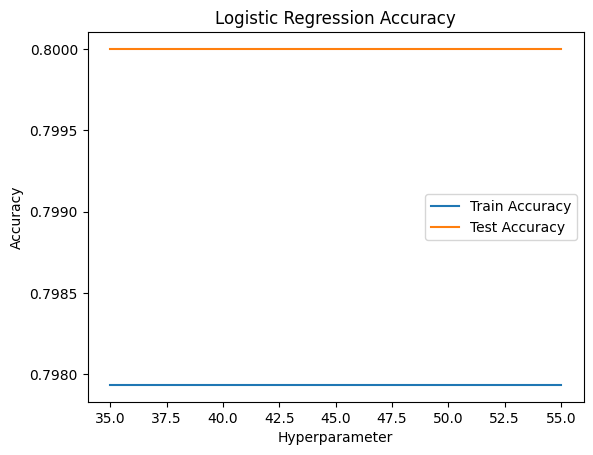

In [205]:
def lr_model(train_pd: pd.DataFrame, test_pd: pd.DataFrame) -> tuple:
    X_train = train_pd["features"].tolist()
    X_test = test_pd["features"].tolist()
    y_train = train_pd["Label"].tolist()
    y_test = test_pd["Label"].tolist()
    test_accuracy = []
    train_accuracy = []
    best_model = None
    best_score = 0

    for max_iter in [35,40,45,50,55]:
        model = LogisticRegression(max_iter=max_iter, random_state=42)
        scores = cross_val_score(model, X_train, y_train, cv=5)
        print(f"max_iter={max_iter}, avg accuracy: {scores.mean()}")
        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        print(f"max_iter={max_iter}, train accuracy: {train_acc}")
        print(f"max_iter={max_iter}, test accuracy: {test_acc}")
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)

        if test_acc > best_score:
            best_score = test_acc
            best_model = model
    best_pred = best_model.predict(X_test)

    return best_pred, train_accuracy, test_accuracy, y_test

y_pred, train_accuracy, test_accuracy, y_test = lr_model(train_pd, test_pd)
plot_accuracy([35,40,45,50,55], train_accuracy, test_accuracy, "Logistic Regression")

Best Logistic Regression accuracy: 0.8


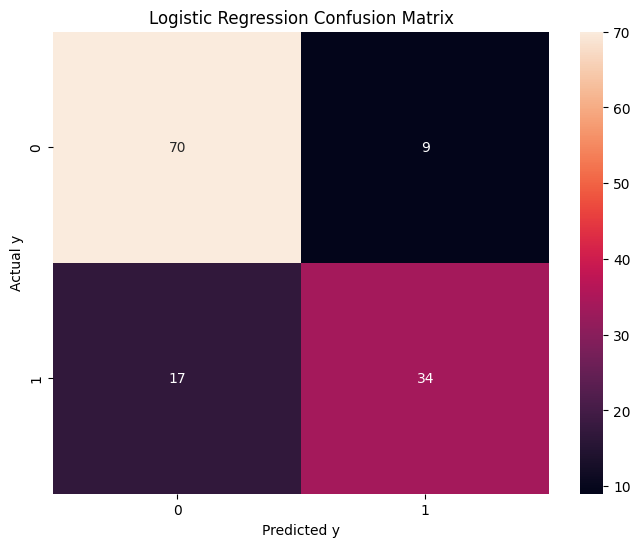

In [206]:
print(f"Best Logistic Regression accuracy: {accuracy_score(y_test, y_pred)}")
create_confusion_matrix(y_test, y_pred, "Logistic Regression")

n_estimators=1, avg accuracy: 0.6799891067538126
n_estimators=1, train accuracy: 0.8864306784660767
n_estimators=1, test accuracy: 0.6461538461538462
n_estimators=10, avg accuracy: 0.7625381263616557
n_estimators=10, train accuracy: 0.9690265486725663
n_estimators=10, test accuracy: 0.7692307692307693
n_estimators=15, avg accuracy: 0.7625272331154684
n_estimators=15, train accuracy: 0.9734513274336283
n_estimators=15, test accuracy: 0.7692307692307693
n_estimators=25, avg accuracy: 0.7654901960784313
n_estimators=25, train accuracy: 0.9793510324483776
n_estimators=25, test accuracy: 0.7846153846153846
n_estimators=50, avg accuracy: 0.7743355119825709
n_estimators=50, train accuracy: 0.9793510324483776
n_estimators=50, test accuracy: 0.7846153846153846
n_estimators=100, avg accuracy: 0.7802178649237473
n_estimators=100, train accuracy: 0.9808259587020649
n_estimators=100, test accuracy: 0.7923076923076923


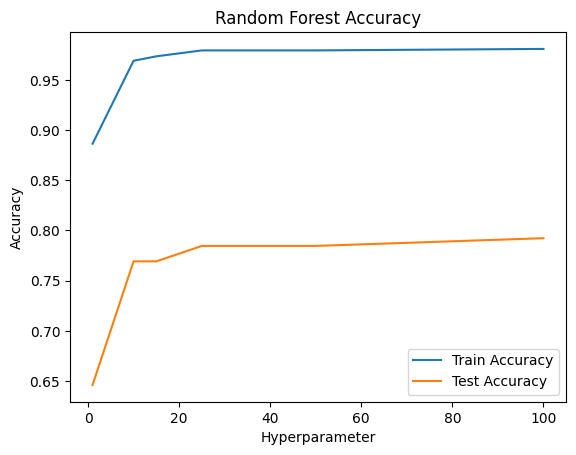

In [207]:
def rf_model(train_pd: pd.DataFrame, test_pd: pd.DataFrame) -> tuple:
    X_train = train_pd["features"].tolist()
    X_test = test_pd["features"].tolist()
    y_train = train_pd["Label"].tolist()
    y_test = test_pd["Label"].tolist()
    test_accuracy = []
    train_accuracy = []
    best_model = None
    best_score = 0

    for n in [1,10,15,25,50,100]:
        model = RandomForestClassifier(n_estimators=n, random_state=42)
        scores = cross_val_score(model, X_train, y_train, cv=5)
        print(f"n_estimators={n}, avg accuracy: {scores.mean()}")
        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        print(f"n_estimators={n}, train accuracy: {train_acc}")
        print(f"n_estimators={n}, test accuracy: {test_acc}")
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)

        if test_acc > best_score:
            best_score = test_acc
            best_model = model
    best_pred = best_model.predict(X_test)

    return best_pred, train_accuracy, test_accuracy, y_test

y_pred, train_accuracy, test_accuracy, y_test = rf_model(train_pd, test_pd)
plot_accuracy([1,10,15,25,50,100], train_accuracy, test_accuracy, "Random Forest")

Best Random Forest accuracy: 0.7923076923076923


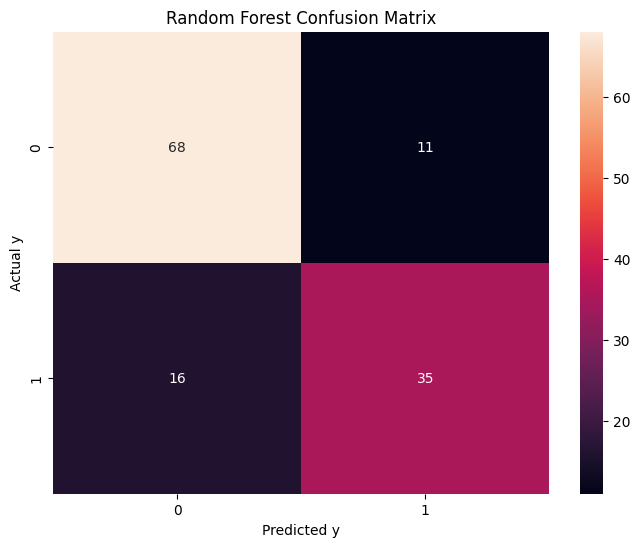

In [208]:
print(f"Best Random Forest accuracy: {accuracy_score(y_test, y_pred)}")
create_confusion_matrix(y_test, y_pred, "Random Forest")

n_neighbors=1, avg accuracy: 0.7226797385620916
n_neighbors=1, train accuracy: 0.9778761061946902
n_neighbors=1, test accuracy: 0.7307692307692307
n_neighbors=5, avg accuracy: 0.7581263616557734
n_neighbors=5, train accuracy: 0.8348082595870207
n_neighbors=5, test accuracy: 0.8307692307692308
n_neighbors=10, avg accuracy: 0.7655119825708061
n_neighbors=10, train accuracy: 0.8097345132743363
n_neighbors=10, test accuracy: 0.7923076923076923
n_neighbors=15, avg accuracy: 0.758169934640523
n_neighbors=15, train accuracy: 0.7949852507374632
n_neighbors=15, test accuracy: 0.8307692307692308


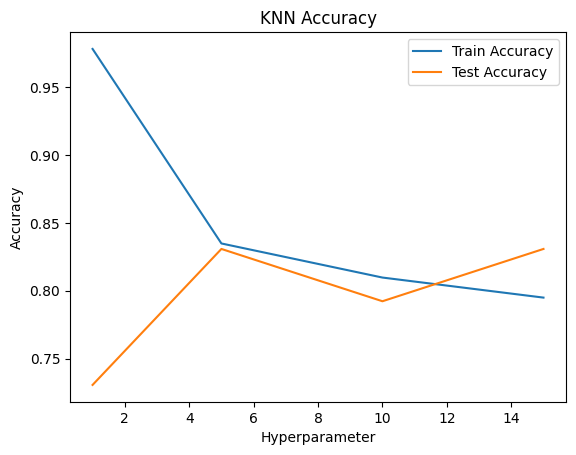

In [209]:
def knn_model(train_pd: pd.DataFrame, test_pd: pd.DataFrame) -> tuple:
    X_train = train_pd["features"].tolist()
    X_test = test_pd["features"].tolist()
    y_train = train_pd["Label"].tolist()
    y_test = test_pd["Label"].tolist()
    test_accuracy = []
    train_accuracy = []
    best_model = None
    best_score = 0

    for n in [1,5,10,15]:
        model = KNeighborsClassifier(n_neighbors=n)
        scores = cross_val_score(model, X_train, y_train, cv=5)
        print(f"n_neighbors={n}, avg accuracy: {scores.mean()}")
        model.fit(X_train, y_train)

        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)

        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        print(f"n_neighbors={n}, train accuracy: {train_acc}")
        print(f"n_neighbors={n}, test accuracy: {test_acc}")
        train_accuracy.append(train_acc)
        test_accuracy.append(test_acc)

        if test_acc > best_score:
            best_score = test_acc
            best_model = model
    best_pred = best_model.predict(X_test)

    return best_pred, train_accuracy, test_accuracy, y_test

y_pred, train_accuracy, test_accuracy, y_test = knn_model(train_pd, test_pd)
plot_accuracy([1,5,10,15], train_accuracy, test_accuracy, "KNN")

Best KNN accuracy: 0.8307692307692308


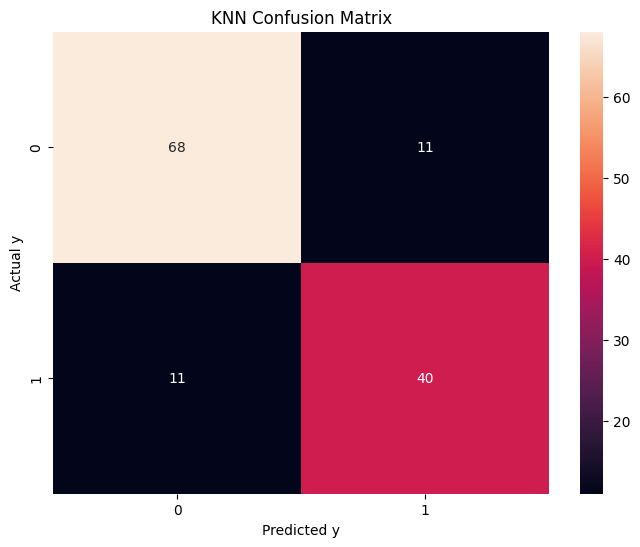

In [210]:
print(f"Best KNN accuracy: {accuracy_score(y_test, y_pred)}")
create_confusion_matrix(y_test, y_pred, "KNN")

Final accuracy: 0.8307692307692308


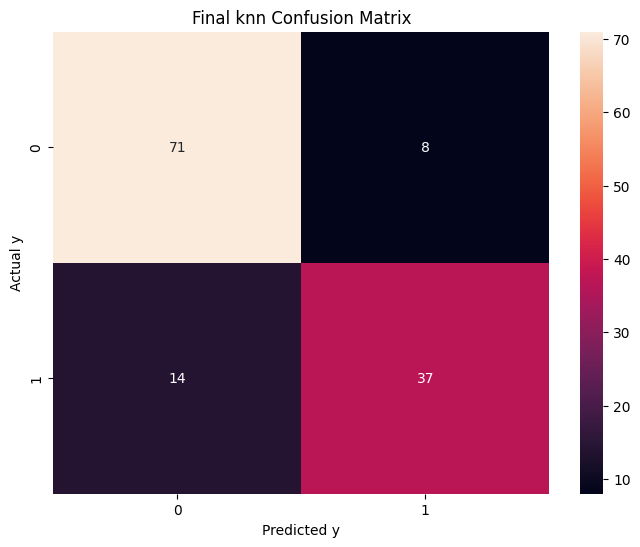

In [212]:
final_model = KNeighborsClassifier(n_neighbors=15)
final_model.fit(train_pd["features"].tolist(), train_pd["Label"].tolist())
y_pred = final_model.predict(test_pd["features"].tolist())
accuracy = accuracy_score(test_pd["Label"].tolist(), y_pred)
print(f"Final accuracy: {accuracy}")
create_confusion_matrix(test_pd["Label"].tolist(), y_pred, "Final knn")


### Write your report here

After loading the data, I conducted initial data analysis to understand the dataset better. The analysis revealed that the dataset had 891 samples and 8 features excluding the PassengerId, Survived, Name, and Ticket columns. I decided to drop Name and Ticket as I think that they don't have any impact on survival. The cabin column had a lot missing values and there were some unreasonable values in the age, parents/children aboard, siblings/spouses aboard, and far columns such as negative ages, negative number of sibling/spouses aboard, fare value of 0.

To clean the data, I first replaced missing age values with the average age of passengers excluding the unreasonable values. For the cabin column, I noticed that first class passengers paid more than 35.5 and had cabin numbers that started with A up to D,while second class passengers paid between 10.5 and 35.4 and had cabin numbers that started with D up to F and third class passengers paid less than 10.5 and had cabin numbers that started with F up to G. I used this information to fill the missing cabin values and missing passenger class values. Giving first class passengers cabin number 'A', second class passengers cabin number 'B', and third class passengers cabin number 'C'. For all other features, I replaced missing values with the mode of the respective feature. I removed three duplicate samples from the dataset. I removed outliers using the 3 standard deviation method
for numerical features, setting specific constraints like limiting ages to 0-100 years and fares to less than 350.

After cleaning the data, I split the dataset into a training set and a test set, using 80-20 split and then standardized numeric features
using the StandardScaler to imporve permanence. I encoded the categorical features using the OneHotEncoder. I then trained the models using the training set and tested the models using the test set.

I implemented and compared four models; SVM, Logistic Regression, Random Forest, and K-Nearest Neighbors. Each model underwent Cross Validation with varying hyperparameters to find the optimal parameter. SVM model had an accuracy of 80.77%, Logistic Regression had an
accuracy of 80%, Random Forest had an accuracy of 79.23%, and K-Nearest Neighbors had an accuracy of 83.08%. I selected K-Nearest Neighbors as the final model since it had the highest accuracy.

---